# 2D autocovariance, synthetica data

We want to compute an autocovariance that spans lags: 

- $(0, T)$ for time, with resolution $dt$. Typically: $T=1$ month, $dt=1$ hour
- $(0, L_x)$ for longitude, with resolution $dx$. Typically: $L_x=1000$ km, $dx=5$ km
- $(0, L_y)$ for latitude, with resolution $dy$. Typically: $L_y=1000$ km, $dy=5$ km

**Strategy for autocovariance:**

We want to find pairs of data that are close enough.
- rolling selection on time: $t_{min} + n T < t_1 < t_{min} + (n+1) T$ and $t_1 < t_2$
- $x_1 \in [i L_x, (i+1) L_x]$, $x_2 \in [(i-1) L_x, (j+1) L_x]$
- $y_1 \in [i L_x, (i+1) L_x]$, $x_2 \in [(i-1) L_x, (j+1) L_x]$
- $|x_1-x_2|<L_x$, $|y_1-y_2|<L_y$

We want this to be scalable





http://kuanbutts.com/2017/06/18/dask-geoprocessing/

https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8

https://geoffboeing.com/2016/10/r-tree-spatial-index-python/

https://blog.mapbox.com/a-dive-into-spatial-search-algorithms-ebd0c5e39d2a

https://automating-gis-processes.github.io/site/notebooks/L3/spatial_index.html

https://github.com/uber/h3-py-notebooks/blob/master/notebooks/urban_analytics.ipynb


In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Polygon, Point
from shapely import wkt
import pyproj
crs_wgs84 = pyproj.CRS("EPSG:4326")

#from dask.delayed import delayed
#import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

#import xgcm
#from h3 import h3
import pyinterp.geohash as geohash
import pyinterp.geodetic as geodetic

---

# synthesis

## spatial selection with geohash (pyinterp) and geopandas


Ocean seas shapefiles from: http://www.naturalearthdata.com/downloads/

In [6]:
def generate_grid_and_geohashes(dl, geohash_resolution=2):
    
    # generate grid
    lon = np.arange(-180, 180, dl)
    lat = np.arange(-80, 80, dl)
    lon2, lat2 = np.meshgrid(lon, lat)
    
    # associated shapely objects and geopandas dataframe
    get_poly = lambda lon, lat, dlon, dlat: ( (lon, lat), (lon+dlon, lat), (lon+dlon, lat+dlat), (lon, lat+dlat), (lon, lat))
    _polygons = [Polygon(get_poly(_lon,_lat, dl, dl)) for _lon, _lat in zip(lon2.flatten(), lat2.flatten())]
    #
    gdf = geopandas.GeoDataFrame(
        None, geometry=_polygons, crs=crs_wgs84
    )

    # filter oceans out
    ocean_shp = "/Users/aponte/Data/shapefiles/ne_110m_ocean/ne_110m_ocean.shp"
    ocean = geopandas.read_file(ocean_shp)
    
    # select only boxes that are within ocean
    gdf = geopandas.sjoin(gdf, ocean, how='inner', op='intersects')
    gdf = gdf.drop(columns=["index_right", "scalerank", "featurecla", "min_zoom"])
    gdf.plot()

    # buffer each polygons
    gdf_buff = gdf.copy()
    gdf_buff['geometry'] = gdf.buffer(dl)    
    
    # geohashes
    hash_boxes = get_geohashes(geohash_resolution)
    
    #_gdf = geopandas.sjoin(gdf, hash_boxes, how='left', op='intersects')
    gdf_hashes = (geopandas
                  .sjoin(gdf_buff, hash_boxes, how='left', op='intersects')
                  .rename(columns=dict(index_right="geohash"))
                 )
    
    return gdf_hashes
    

def get_geohashes(resolution):
 
    # generate all geohases for one resolution
    codes = geohash.bounding_boxes(None, precision=2)

    hash_boxes = geopandas.GeoDataFrame(
        {'geohash': codes}, 
        geometry=[wkt.loads(geohash.bounding_box(code).wkt()) for code in codes], 
        crs=crs_wgs84,
    ).set_index("geohash")
    
    return hash_boxes    


<ipython-input-6-038e0e960e52>:27: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buff['geometry'] = gdf.buffer(dl)


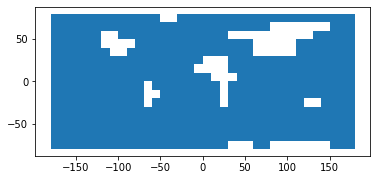

In [11]:
precision = 2
df_boxes = generate_grid_and_geohashes(10, geohash_resolution=precision)
hash_boxes = get_geohashes(precision)

In [16]:
# generate synthetic data

_lon = np.random.randn(100000)*180
_lon = ( (_lon+180)%360 - 180 )
_lat = np.random.randn(100000)*80

df = pd.DataFrame(
    dict(lon=_lon,
         lat=_lat,
         geohash=geohash.encode(_lon, _lat, precision=precision),
        )
)
df = df[ (df.lat>-90)& (df.lat<90)]
df = df.set_index("geohash")
df.head()

,lon,lat
geohash,,
b'8t',-148.331846,32.163754
b'nw',121.079690,-50.980682
b'6x',-64.969397,-2.100317
b'wp',91.344632,40.251348
b'9g',-93.289759,21.210834


,lon,lat,geometry,index_right,geohash
geohash,,,,,
b'j5',51.459399,-71.091661,POINT (51.45940 -71.09166),60,b'j9'
b'j5',52.849133,-67.566340,POINT (52.84913 -67.56634),60,b'j9'
b'j5',50.024378,-68.104616,POINT (50.02438 -68.10462),60,b'j9'
b'j5',50.394886,-68.950848,POINT (50.39489 -68.95085),60,b'j9'
b'j5',53.181547,-68.741248,POINT (53.18155 -68.74125),60,b'j9'


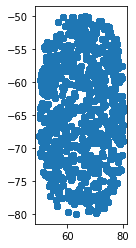

In [21]:
# test with one box

idx = 60
_box = df_boxes.loc[df_boxes.index==idx]

# keep only valid geohashes where points are found
valid_geohash = df.index.intersection(_box.loc[:,"geohash"].values)

# first guess based on geohashes
df_fguess = df.loc[valid_geohash]
df_fguess.head()

# transform into geopandas dataframe
gdf_fguess = geopandas.GeoDataFrame(
    df_fguess, 
    geometry=geopandas.points_from_xy(df_fguess.lon, df_fguess.lat),
    crs=crs_wgs84,
)

# narrow selection
gdf_narrow = geopandas.sjoin(gdf_fguess, _box, how='inner', op='intersects')
gdf_narrow.plot()
gdf_narrow.head()

---

# dev

In [2]:
dl=5 # deg

lon = np.arange(-180, 180, dl)
lat = np.arange(-80, 80, dl)
lon2, lat2 = np.meshgrid(lon, lat)

In [3]:
# generate shapely object
get_poly = lambda lon, lat, dlon, dlat: ( (lon, lat), (lon+dlon, lat), (lon+dlon, lat+dlat), (lon, lat+dlat), (lon, lat))

_polygons = [Polygon(get_poly(_lon,_lat, dl, dl)) for _lon, _lat in zip(lon2.flatten(), lat2.flatten())]
# geopandas dataframe with projection immediately transformed to deal with dateline issues
poly_gdf = geopandas.GeoDataFrame(
    None, geometry=_polygons, crs=crs_wgs84
)

In [4]:
poly_gdf

,geometry
0,"POLYGON ((-180.00000 -80.00000, -175.00000 -80..."
1,"POLYGON ((-175.00000 -80.00000, -170.00000 -80..."
2,"POLYGON ((-170.00000 -80.00000, -165.00000 -80..."
3,"POLYGON ((-165.00000 -80.00000, -160.00000 -80..."
4,"POLYGON ((-160.00000 -80.00000, -155.00000 -80..."
...,...
2299,"POLYGON ((155.00000 75.00000, 160.00000 75.000..."
2300,"POLYGON ((160.00000 75.00000, 165.00000 75.000..."
2301,"POLYGON ((165.00000 75.00000, 170.00000 75.000..."
2302,"POLYGON ((170.00000 75.00000, 175.00000 75.000..."


In [5]:
# dismiss boxes that do not interest oceans

# 
#ocean_shp = "/Users/aponte/Data/shapefiles/World_Seas_IHO_v3/World_Seas_IHO_v3.shp"
# http://www.naturalearthdata.com/downloads/
ocean_shp = "/Users/aponte/Data/shapefiles/ne_110m_ocean/ne_110m_ocean.shp"

gdf = geopandas.read_file(ocean_shp)
#gdf = gdf.rename(columns={c: c.lower() for c in gdf.columns})
gdf

,scalerank,featurecla,min_zoom,geometry
0,0,Ocean,0.0,"POLYGON ((49.110 41.282, 48.584 41.809, 47.492..."
1,0,Ocean,0.0,"POLYGON ((180.000 71.516, 178.725 71.099, 178...."


<AxesSubplot:>

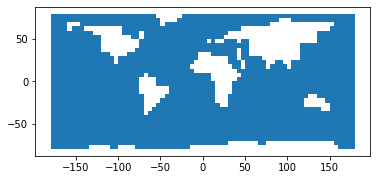

In [25]:
# select only boxes that are within ocean
poly_oceans = geopandas.sjoin(poly_gdf, gdf, how='inner', op='intersects')
poly_oceans = poly_oceans.drop(columns=["index_right", "scalerank", "featurecla", "min_zoom"])
poly_oceans.plot()

In [147]:
# buffer each polygons
poly_oceans_buff = poly_oceans.copy()
poly_oceans_buff['geometry'] = poly_oceans.buffer(dl)

<ipython-input-147-22426b2c9157>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poly_oceans_buff['geometry'] = poly_oceans.buffer(dl)


In [148]:
# find overlapping geoindexes

# generate all geohases for one resolution
codes = geohash.bounding_boxes(None, precision=2)

hash_boxes = geopandas.GeoDataFrame(
    {'geohash': codes}, 
    geometry=[wkt.loads(geohash.bounding_box(code).wkt()) for code in codes], 
    crs=crs_wgs84,
).set_index("geohash")
hash_boxes

,geometry
geohash,
b'00',"POLYGON ((-180.00000 -90.00000, -180.00000 -84..."
b'02',"POLYGON ((-168.75000 -90.00000, -168.75000 -84..."
b'08',"POLYGON ((-157.50000 -90.00000, -157.50000 -84..."
b'0b',"POLYGON ((-146.25000 -90.00000, -146.25000 -84..."
b'10',"POLYGON ((-135.00000 -90.00000, -135.00000 -84..."
...,...
b'yz',"POLYGON ((123.75000 84.37500, 123.75000 90.000..."
b'zp',"POLYGON ((135.00000 84.37500, 135.00000 90.000..."
b'zr',"POLYGON ((146.25000 84.37500, 146.25000 90.000..."


In [150]:
#_gdf = geopandas.sjoin(poly_oceans, hash_boxes, how='left', op='intersects')
_gdf = geopandas.sjoin(poly_oceans_buff, hash_boxes, how='left', op='intersects')
_gdf = _gdf.rename(columns=dict(index_right="geohash"))
#_gdf.loc[_gdf.index.duplicated()]
_gdf

,geometry,geohash
0,"POLYGON ((-185.000 -80.000, -185.000 -75.000, ...",b'00'
0,"POLYGON ((-185.000 -80.000, -185.000 -75.000, ...",b'01'
0,"POLYGON ((-185.000 -80.000, -185.000 -75.000, ...",b'04'
0,"POLYGON ((-185.000 -80.000, -185.000 -75.000, ...",b'05'
1,"POLYGON ((-180.000 -80.000, -180.000 -75.000, ...",b'00'
...,...,...
1846,"POLYGON ((45.000 45.000, 45.000 50.000, 45.024...",b'v3'
1846,"POLYGON ((45.000 45.000, 45.000 50.000, 45.024...",b'v1'
1846,"POLYGON ((45.000 45.000, 45.000 50.000, 45.024...",b'tp'
1846,"POLYGON ((45.000 45.000, 45.000 50.000, 45.024...",b'sz'


Text(0.5, 1.0, '2    POLYGON ((-170.00000 -80.00000, -165.00000 -80...\nName: geometry, dtype: geometry')

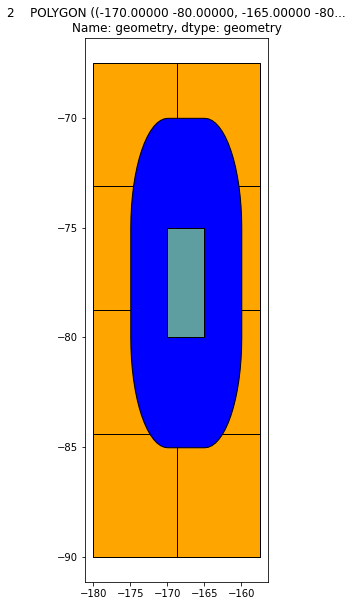

In [154]:
idx = 2

_poly = poly_oceans.loc[poly_oceans.index==idx]
ax = _poly.plot(color="cadetblue", edgecolor="k", figsize=(16,10),)

_polyb = poly_oceans_buff.loc[poly_oceans_buff.index==idx]
_polyb.plot(ax=ax, color="blue", edgecolor="k", zorder=0)

for _, b in _gdf.loc[_gdf.index==idx].iterrows():
    _hash_boxes = hash_boxes.loc[hash_boxes.index==b['geohash']]
    _hash_boxes.plot(ax=ax, color="orange", edgecolor="k",zorder=-1)
ax.set_title(str(_poly["geometry"]))

In [155]:
list(_gdf.loc[_gdf.index==idx].loc[:,"geohash"])

[b'00', b'02', b'01', b'03', b'04', b'06', b'07', b'05']

In [156]:
b'01' in list(_gdf.loc[_gdf.index==idx].loc[:,"geohash"])

True

### try spatial selection on synthetic data

In [224]:
# generate synthetic data

_lon = np.random.randn(10000)*180
_lon = ( (_lon+180)%360 - 180 )
_lat = np.random.randn(10000)*80

df = pd.DataFrame(
    dict(lon=_lon,
         lat=_lat,
         geohash=geohash.encode(_lon, _lat, precision=precision),
        )
)
df = df[ (df.lat>-90)& (df.lat<90)]
df = df.set_index("geohash")
df.head()

,lon,lat
geohash,,
b'k2',16.978565,-42.805240
b'y6',104.299992,59.038788
b'5x',-13.990361,-45.083692
b'0k',-162.985756,-64.973146
b'23',-160.614993,-34.545519


In [241]:
# find all points within one domain
idx = 2
_box = df_boxes.loc[df_boxes.index==idx]

# keep only valid geohashes where points are found
valid_geohash = df.index.intersection(_box.loc[:,"geohash"].values)

# first guess based on geohashes
df_fguess = df.loc[valid_geohash]
df_fguess.head()

# transform into geopandas dataframe
gdf_fguess = geopandas.GeoDataFrame(
    df_fguess, 
    geometry=geopandas.points_from_xy(df_fguess.lon, df_fguess.lat),
)

# narrow selection
gdf_narrow = geopandas.sjoin(gdf_fguess, _box, how='inner', op='intersects')
gdf_narrow.head()

,lon,lat
geohash,,
b'03',-166.615510,-79.211605
b'03',-168.690742,-83.014364
b'03',-168.586425,-78.831856
b'03',-161.520435,-83.493275
b'03',-157.663540,-80.896102


<AxesSubplot:>

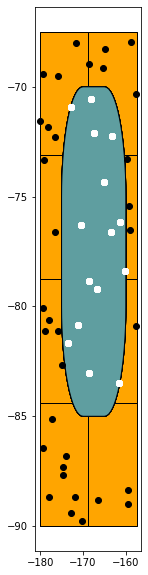

In [248]:
# find all points within one domain

ax = _boxes.plot(color="cadetblue", edgecolor="k", figsize=(16,10),)

# first guess
gdf_fguess.plot(ax=ax, color='k')
gdf_narrow.plot(ax=ax, color='w')

hash_boxes.loc[valid_geohash].plot(ax=ax, color="orange", edgecolor="k",zorder=-1)

In [2]:
import timeit
import cartopy.crs
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot
import numpy
import pandas
#
#import pyinterp.geohash
#import pyinterp.geodetic

In [5]:
def _sort_colors(colors):
    """Sort colors by hue, saturation, value and name in descending order"""
    by_hsv = sorted(
        (tuple(matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb(color))),
         name) for name, color in colors.items())
    return [name for hsv, name in reversed(by_hsv)]


def _plot_box(ax, code, color, caption=True):
    """Plot a GeoHash bounding box"""
    box = geohash.bounding_box(code)
    x0 = box.min_corner.lon
    x1 = box.max_corner.lon
    y0 = box.min_corner.lat
    y1 = box.max_corner.lat
    dx = x1 - x0
    dy = y1 - y0
    box = matplotlib.patches.Rectangle((x0, y0),
                                       dx,
                                       dy,
                                       alpha=0.5,
                                       color=color,
                                       ec="black",
                                       lw=1,
                                       transform=cartopy.crs.PlateCarree())
    ax.add_artist(box)
    if not caption:
        return
    rx, ry = box.get_xy()
    cx = rx + box.get_width() * 0.5
    cy = ry + box.get_height() * 0.5
    ax.annotate(code.decode(), (cx, cy),
                color='w',
                weight='bold',
                fontsize=16,
                ha='center',
                va='center')


def plot_geohash_grid(precision,
                      points=None,
                      box=None,
                      color_list=None,
                      inc=7):
    """Plot geohash bounding boxes"""
    color_list = color_list or matplotlib.colors.CSS4_COLORS
    fig = matplotlib.pyplot.figure(figsize=(24, 12))
    ax = fig.add_subplot(1, 1, 1, projection=cartopy.crs.PlateCarree())
    if box is not None:
        ax.set_extent([
            box.min_corner.lon, box.max_corner.lon, box.min_corner.lat,
            box.max_corner.lat
        ],
                      crs=cartopy.crs.PlateCarree())
    if points is not None:
        xmin, xmax = points['lon'].min(), points['lon'].max()
        ymin, ymax = points['lat'].min(), points['lat'].max()
        if box is None:
            ax.set_xlim((xmin - 4, xmax + 4))
            ax.set_ylim((ymin - 4, ymax + 4))

        ax.plot(points['lon'],
                points['lat'],
                color='black',
                marker=".",
                ls='',
                ms='0.5',
                transform=cartopy.crs.PlateCarree())
    colors = _sort_colors(color_list)
    ic = 0
    codes = geohash.bounding_boxes(box, precision=precision)
    color_codes = {codes[0][0]: colors[ic]}
    for item in codes:
        prefix = item[precision - 1]
        if prefix not in color_codes:
            ic += inc
            color_codes[prefix] = colors[ic % len(colors)]
        _plot_box(ax, item, color_codes[prefix], True)
    ax.stock_img()
    ax.coastlines()
    ax.grid()

In [1]:
plot_geohash_grid(1)

NameError: name 'plot_geohash_grid' is not defined

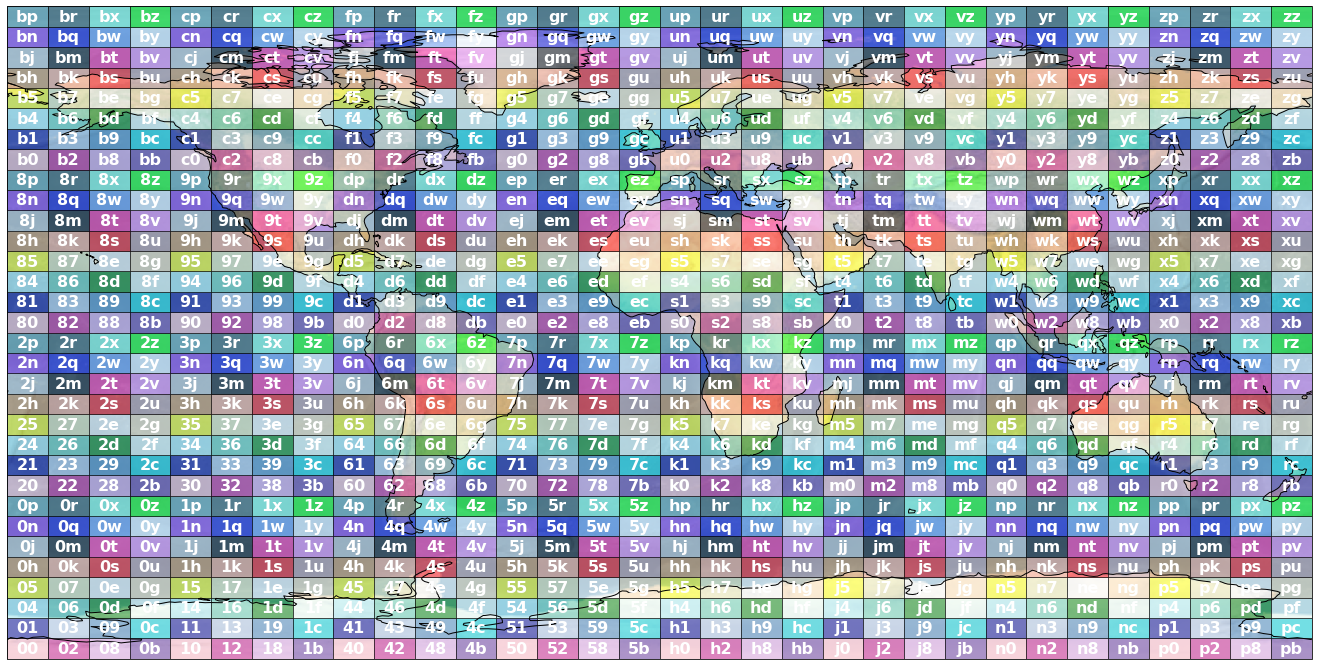

In [7]:
plot_geohash_grid(2)

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


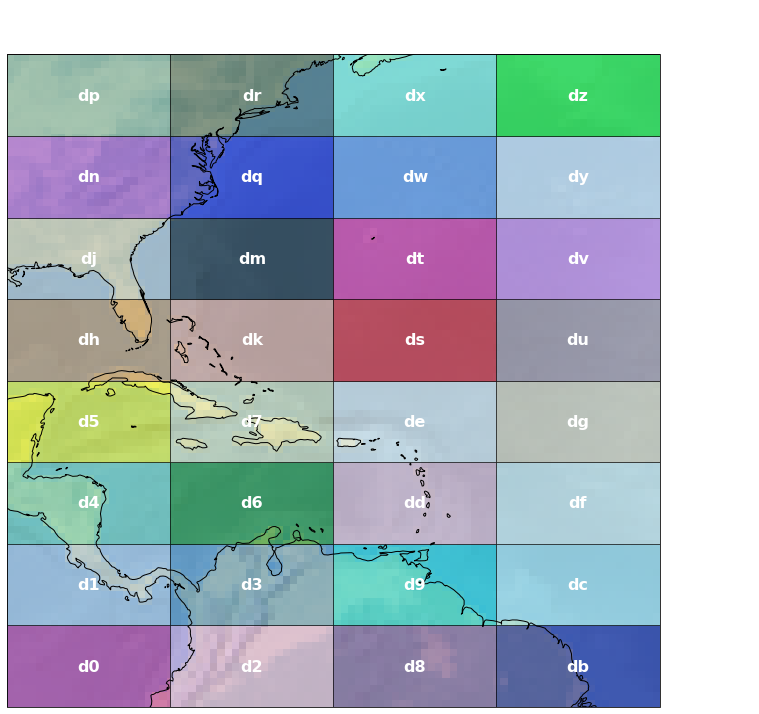

In [9]:
plot_geohash_grid(2, box=geohash.bounding_box('d'))

In [12]:
codes = geohash.bounding_boxes(None, precision=1)
codes

array([b'0', b'1', b'4', b'5', b'h', b'j', b'n', b'p', b'2', b'3', b'6',
       b'7', b'k', b'm', b'q', b'r', b'8', b'9', b'd', b'e', b's', b't',
       b'w', b'x', b'b', b'c', b'f', b'g', b'u', b'v', b'y', b'z'],
      dtype='|S1')

In [17]:
box = geohash.bounding_box(codes[0])
box

((-180, -90), (-135, -45))

In [19]:
box.wkt()

'POLYGON((-180 -90,-180 -45,-135 -45,-135 -90,-180 -90))'

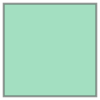

In [23]:
wkt.loads(box.wkt())

In [27]:
hash_boxes = geopandas.GeoDataFrame(
    None, geometry=[wkt.loads(geohash.bounding_box(code).wkt()) for code in codes], crs=crs_wgs84
)
hash_boxes

,geometry
0,"POLYGON ((-180.00000 -90.00000, -180.00000 -45..."
1,"POLYGON ((-135.00000 -90.00000, -135.00000 -45..."
2,"POLYGON ((-90.00000 -90.00000, -90.00000 -45.0..."
3,"POLYGON ((-45.00000 -90.00000, -45.00000 -45.0..."
4,"POLYGON ((0.00000 -90.00000, 0.00000 -45.00000..."
5,"POLYGON ((45.00000 -90.00000, 45.00000 -45.000..."
6,"POLYGON ((90.00000 -90.00000, 90.00000 -45.000..."
7,"POLYGON ((135.00000 -90.00000, 135.00000 -45.0..."
8,"POLYGON ((-180.00000 -45.00000, -180.00000 0.0..."
9,"POLYGON ((-135.00000 -45.00000, -135.00000 0.0..."
